In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"praneethratna","key":"293ec57c31db42be6e3f9d2fc4e7a438"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d gpiosenka/100-bird-species
!mkdir data
! unzip 100-bird-species.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/train/TOWNSENDS WARBLER/091.jpg  
  inflating: data/train/TOWNSENDS WARBLER/092.jpg  
  inflating: data/train/TOWNSENDS WARBLER/093.jpg  
  inflating: data/train/TOWNSENDS WARBLER/094.jpg  
  inflating: data/train/TOWNSENDS WARBLER/095.jpg  
  inflating: data/train/TOWNSENDS WARBLER/096.jpg  
  inflating: data/train/TOWNSENDS WARBLER/097.jpg  
  inflating: data/train/TOWNSENDS WARBLER/098.jpg  
  inflating: data/train/TOWNSENDS WARBLER/099.jpg  
  inflating: data/train/TOWNSENDS WARBLER/100.jpg  
  inflating: data/train/TOWNSENDS WARBLER/101.jpg  
  inflating: data/train/TOWNSENDS WARBLER/102.jpg  
  inflating: data/train/TOWNSENDS WARBLER/103.jpg  
  inflating: data/train/TOWNSENDS WARBLER/104.jpg  
  inflating: data/train/TOWNSENDS WARBLER/105.jpg  
  inflating: data/train/TOWNSENDS WARBLER/106.jpg  
  inflating: data/train/TOWNSENDS WARBLER/107.jpg  
  inflating: data/train/TOWNSENDS WARBLER/108.jpg  
  inflating: 

In [5]:
from urllib.request import urlretrieve
import tensorflow as tf
import os
from tensorflow import keras
from keras.layers import Dense , Flatten , GlobalAveragePooling2D , Dropout ,BatchNormalization
from keras import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import Adam
import math

In [6]:
TRAIN_PATH = '/content/' + '/data/train/'
VAL_PATH = '/content/' + '/data/test/'
train = ImageDataGenerator(rescale = 1./255,
                           rotation_range=10,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           horizontal_flip=True,
                           shear_range=0.2)
train_datagen = train.flow_from_directory(TRAIN_PATH,target_size= (224,224),class_mode = 'categorical',batch_size = 1024)
val = ImageDataGenerator(rescale = 1./255,
                         rotation_range=10,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         horizontal_flip=True,
                         shear_range=0.2)
val_datagen = val.flow_from_directory(VAL_PATH,target_size= (224,224),class_mode = 'categorical',batch_size = 1024)

Found 39364 images belonging to 275 classes.
Found 1375 images belonging to 275 classes.


In [7]:
weightsurl = "https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weightspath = 'inceptionweights.h5'
urlretrieve(weightsurl,weightspath)
pretrained = InceptionV3(input_shape=(224,224,3),include_top=False,weights='imagenet')
for layer in pretrained.layers:
  layer.trainable = False

87924736/87910968 [==============================] - 1s 0us/step


In [8]:
# pretrained.summary()
layer = pretrained.get_layer('mixed7')
output = layer.output

In [19]:
x = GlobalAveragePooling2D()(output)
x = Flatten()(x)
x = Dense(units = 512,activation= 'relu')(x)
x = Dropout(0.3)(x)
x = Dense(units = 512,activation= 'relu')(x)
x = Dropout(0.1)(x)
x = Dense(units=275,activation='softmax')(x)

model = Model(inputs = pretrained.input,outputs = x)

In [25]:
model.compile(optimizer=Adam(learning_rate = 0.01),loss = 'categorical_crossentropy',metrics = ['acc'])


In [26]:
model.load_weights('weights.h5')

In [55]:
TRAIN_STEPS = math.floor(39364/1024)
VAL_STEPS=math.floor(1375/1024)
history = model.fit(train_datagen,epochs=20,verbose=1,validation_data=val_datagen,
                    steps_per_epoch = TRAIN_STEPS,
                    validation_steps=VAL_STEPS)
model.save_weights('weights.h5')

Epoch 1/20
38/38 [==============================] - 426s 11s/step - loss: 5.2597 - acc: 0.0270 - val_loss: 2.6311 - val_acc: 0.3838
Epoch 2/20
38/38 [==============================] - 392s 10s/step - loss: 3.0211 - acc: 0.2458 - val_loss: 1.5194 - val_acc: 0.6006
Epoch 3/20
38/38 [==============================] - 391s 10s/step - loss: 2.3498 - acc: 0.3759 - val_loss: 1.0852 - val_acc: 0.7363
Epoch 4/20
38/38 [==============================] - 391s 10s/step - loss: 2.1021 - acc: 0.4260 - val_loss: 0.9100 - val_acc: 0.7686
Epoch 5/20
38/38 [==============================] - 390s 10s/step - loss: 1.9037 - acc: 0.4794 - val_loss: 0.7942 - val_acc: 0.7949
Epoch 6/20
38/38 [==============================] - 391s 10s/step - loss: 1.8133 - acc: 0.5026 - val_loss: 0.7560 - val_acc: 0.7998
Epoch 7/20
38/38 [==============================] - 391s 10s/step - loss: 1.7131 - acc: 0.5274 - val_loss: 0.6502 - val_acc: 0.8174
Epoch 8/20
38/38 [==============================] - 393s 10s/step - loss: 1.

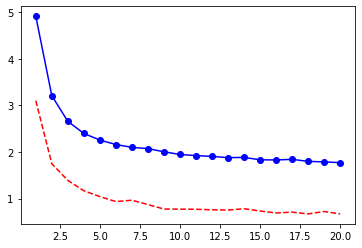

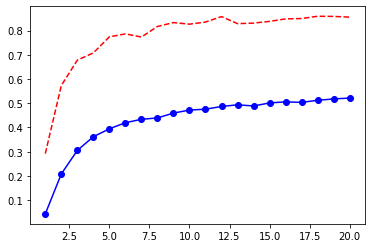

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1,len(acc)+1)

plt.plot(epochs,loss,'bo-',name = "Training loss")
plt.plot(epochs,val_loss,'r--',name = "Validation loss")
plt.title("Training and Validation loss vs Epochs")
plt.show()

plt.plot(epochs,acc,'bo-',name = "Training accuracy")
plt.plot(epochs,val_acc,'r--',name = "Validation accuracy")
plt.title("Training and Validation accuracy vs Epochs")
plt.show()
plt.legend()


In [27]:
types = list(train_datagen.class_indices)
from google.colab import files
images  = files.upload()

Saving 944f9cf6edc6b046cfa32d3752e6c874.jpg to 944f9cf6edc6b046cfa32d3752e6c874.jpg
Saving 5325a3cf-f1cf-4392-9d8d-3377ef32cb60.jpg to 5325a3cf-f1cf-4392-9d8d-3377ef32cb60.jpg
Saving 9437877c-f56b-45ca-a337-de7ba6779802.jpg to 9437877c-f56b-45ca-a337-de7ba6779802.jpg
Saving ask-bald-eagle-istock_000017215186large-2.jpg to ask-bald-eagle-istock_000017215186large-2.jpg


In [28]:
from keras.preprocessing.image import load_img , img_to_array

for fn in images.keys():
  img = '/content/' + fn
  y = load_img(img,target_size=(224,224))
  x = img_to_array(y)
  x = x/255
  x = np.expand_dims(x,axis=0)
  prediction = model.predict(x)
  print("The image you uploaded is an {} 🙂".format(types[np.argmax(prediction)]))


The image you uploaded is an AFRICAN CROWNED CRANE 🙂
The image you uploaded is an WATTLED CURASSOW 🙂
The image you uploaded is an NORTHERN MOCKINGBIRD 🙂
The image you uploaded is an BALD EAGLE 🙂


In [1]:
!git init

Initialized empty Git repository in C:/Users/RATNA PRANEETH/Downloads/.git/


In [39]:
!git add .

In [42]:
!git commit -m "275 birds classifier"

[master (root-commit) 1c81aeb] 275 birds classifier
 16 files changed, 647 insertions(+)
 create mode 100644 .config/.last_opt_in_prompt.yaml
 create mode 100644 .config/.last_survey_prompt.yaml
 create mode 100644 .config/.last_update_check.json
 create mode 100644 .config/active_config
 create mode 100644 .config/config_sentinel
 create mode 100644 .config/configurations/config_default
 create mode 100644 .config/gce
 create mode 100644 .config/logs/2021.06.15/13.36.40.402408.log
 create mode 100644 .config/logs/2021.06.15/13.36.59.704686.log
 create mode 100644 .config/logs/2021.06.15/13.37.15.895583.log
 create mode 100644 .config/logs/2021.06.15/13.37.22.745818.log
 create mode 100644 .config/logs/2021.06.15/13.37.39.858399.log
 create mode 100644 .config/logs/2021.06.15/13.37.40.569743.log
 create mode 100644 inceptionweights.h5
 create mode 100644 kaggle.json
 create mode 100644 weights.h5


In [43]:
!git remote add origin https://github.com/praneethratna/InceptionV3-275-Birds-Kaggle-Dataset.git

In [44]:
!git push origin master

fatal: could not read Username for 'https://github.com': No such device or address
